### Import necessary libraries

In [2]:
#Machine Learning
import os
import tensorflow as tf
import keras
from keras import layers
#Maths/Plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

2023-09-07 22:31:52.381976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 22:31:52.552864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 22:31:52.553794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 22:31:53.907145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Set the parameters

In [3]:
#Parameters
k_f_0, k_r_0, k_cat_0 = [0.71, 0.97], [19, 7000], [6700, 10000]
params_0 = [k_f_0,k_r_0,k_cat_0]
s0, e, s1, s2 = 5.0, 0.66, 0, 0
val_0 = np.array([s0,s1,s2]) #Start values

def param(k_f, k_r, k_cat):
    k1 = e*((k_f[0]*k_cat[0])/(k_r[0]+k_cat[0]))
    k2 = e*((k_f[1]*k_cat[1])/(k_r[1]+k_cat[1]))
    pi = k_cat[1]/(k_r[1]+k_cat[1]) #zero-based indexing
    return k1, k2, pi

### Set up the differential equation function

In [4]:
def f(val, params):
    k1, k2, pi = param(params[0], params[1], params[2])
    mul_ar = np.array([[-k1, 0, 0],
                       [k1*(1-pi), -k2, 0],
                       [k1*pi, k2, 0]])
    return mul_ar.dot(val)

### Runge-Kutta method

In [5]:
#Runge-Kutta method
def f_rk(val, params, dt):
    k_1 = f(val, params)*dt
    k_2 = f(val + 0.5*k_1, params)*dt
    k_3 = f(val + 0.5*k_2, params)*dt
    k_4 = f(val + k_3, params)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval

data_map_train_in, data_map_train_out, data_map_test_in, data_map_test_out, data_dif_train_in, data_dif_train_out, data_dif_test_in, data_dif_test_out = [], [], [], [], [], [], [], []

def integration(params, dt, steps, train):
    global data_map_train_in, data_map_train_out, data_map_test_in, data_map_test_out, data_dif_train_in, data_dif_train_out, data_dif_test_in, data_dif_test_out
    res = []
    res.append([0.0, val_0, val_0])
    val_rk = val_0
    time = 0.0
    for i in range(steps):
        if(train):
            data_map_train_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
            data_map_train_out.append(f_rk(val_rk, params, dt))
            data_dif_train_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
            data_dif_train_out.append(f(val_rk, params))
        else:
            data_map_test_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
            data_map_test_out.append(f_rk(val_rk, params, dt))
            data_dif_test_in.append([val_rk[0], val_rk[1], val_rk[2], params[0][0], params[0][1], params[1][0], params[1][1], params[2][0], params[2][1]])
            data_dif_test_out.append(f(val_rk, params))
        val_rk = f_rk(val_rk, params, dt)
        time += dt
        res.append([time, val_rk])
        #print(i, [time, val_rk])
    res = np.array(res, dtype = object)
    return res

### Plotting the results and collecting data for Neural Network training

In [6]:
# Plot
# ax = plt.figure().add_subplot(projection='3d')
# ax2 = plt.figure().add_subplot()
# ax3 = plt.figure().add_subplot()
# ax4 = plt.figure().add_subplot()

def add_trajectory(params, train, dt=0.2, steps=200):
    res = integration(params, dt, steps, train)
    # ax.plot([row[1][0] for row in res], [row[1][1] for row in res], [row[1][2] for row in res], color="blue")#Runge Kutta plot
    # ax2.plot([row[0] for row in res], [row[1][0] for row in res], color="green")
    # ax3.plot([row[0] for row in res], [row[1][1] for row in res], color="red")
    # ax4.plot([row[0] for row in res], [row[1][2] for row in res], color="orange")

ran_sam = np.random.random_sample(size=(2000, 3, 2))
ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
train_params = []
test_params = []
for s in ran_sam:
    params = np.array(params_0)-np.multiply(params_0,s)
    if(random.random() < 0.8):#80% probability of going to train
        train = True
        train_params.append(params)
    else:
        train = False
        test_params.append(params)
    add_trajectory(params, train)

# space_sam = np.linspace(-0.2, 0.2, num=4)
# twod_sam = np.array(np.meshgrid(space_sam, space_sam)).T.reshape(-1, 2)#deviation for each pair of parameters

# for i in twod_sam:
#     for j in twod_sam:
#         for k in twod_sam:
#             #apply the deviation to each parameter separately
#             dev = np.array([i,j,k])
#             add_trajectory(np.array(params_0)+np.multiply(params_0,dev))

#collect data from the trajectories for training/testing
data_map_train_in = np.array(data_map_train_in, dtype = object)
data_map_test_in = np.array(data_map_test_in, dtype = object)
data_map_train_out = np.array(data_map_train_out, dtype = object)
data_map_test_out = np.array(data_map_test_out, dtype = object)
data_dif_train_in = np.array(data_dif_train_in, dtype = object)
data_dif_test_in = np.array(data_dif_test_in, dtype = object)
data_dif_train_out = np.array(data_dif_train_out, dtype = object)
data_dif_test_out = np.array(data_dif_test_out, dtype = object)

# plt.rcParams["figure.autolayout"] = True
# leg = plt.legend(loc='upper right')
# # Set axes labels
# ax.set_xlabel("S0")
# ax.set_ylabel("S1")
# ax.set_zlabel("S2")
# ax.set_title("System Trajectories")

# ax2.set_xlabel("Time")
# ax2.set_ylabel("Value")
# ax2.set_title("S0 Trajectory")

# ax3.set_xlabel("Time")
# ax3.set_ylabel("Value")
# ax3.set_title("S1 Trajectory")

# ax4.set_xlabel("Time")
# ax4.set_ylabel("Value")
# ax4.set_title("S2 Trajectory")

# plt.show()

### Making training and test data

In [7]:
#separating training from testing data and features from labels
data_map_train_pdin = pd.DataFrame(data_map_train_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_map_train_pdout = pd.DataFrame(data_map_train_out.tolist(), columns = ["nS0","nS1","nS2"])#n means new
data_map_train_pd = pd.concat([data_map_train_pdin,data_map_train_pdout],axis=1)
data_map_test_pdin = pd.DataFrame(data_map_test_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_map_test_pdout = pd.DataFrame(data_map_test_out.tolist(), columns = ["nS0","nS1","nS2"])#n means new
data_map_test_pd = pd.concat([data_map_test_pdin,data_map_test_pdout],axis=1)
data_dif_train_pdin = pd.DataFrame(data_dif_train_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_dif_train_pdout = pd.DataFrame(data_dif_train_out.tolist(), columns = ["dotS0","dotS1","dotS2"])
data_dif_train_pd = pd.concat([data_dif_train_pdin,data_dif_train_pdout],axis=1)
data_dif_test_pdin = pd.DataFrame(data_dif_test_in.tolist(), columns = ["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"])
data_dif_test_pdout = pd.DataFrame(data_dif_test_out.tolist(), columns = ["dotS0","dotS1","dotS2"])
data_dif_test_pd = pd.concat([data_dif_test_pdin,data_dif_test_pdout],axis=1)

# train_map = data_map_pd.sample(frac=0.8, random_state=0)
# test_map = data_map_pd.drop(train_map.index)

# train_dif = data_dif_pd.sample(frac=0.8, random_state=0)
# test_dif = data_dif_pd.drop(train_dif.index)

train_map = data_map_train_pd
test_map = data_map_test_pd

train_dif = data_dif_train_pd
test_dif = data_dif_test_pd

train_map_features = np.asarray(train_map[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy())
train_map_labels = np.asarray(train_map[["nS0","nS1","nS2"]].copy())
test_map_features = np.asarray(test_map[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy())
test_map_labels = np.asarray(test_map[["nS0","nS1","nS2"]].copy())

train_dif_features = train_dif[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy()
train_dif_labels = train_dif[["dotS0","dotS1","dotS2"]].copy()
test_dif_features = test_dif[["S0","S1","S2","KF1", "KF2", "KR1", "KR2", "KCAT1", "KCAT2"]].copy()
test_dif_labels = test_dif[["dotS0","dotS1","dotS2"]].copy()

### Building and training the time-1 map model

In [8]:
normalizer_map = layers.Normalization(axis=-1)
normalizer_map.adapt(np.array(train_map_features))
model_map = keras.Sequential(
    [
        normalizer_map,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_map.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_map.summary()

history_map = model_map.fit(
    train_map_features,
    train_map_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

model_map.save("model_map_params.tf", save_format="tf")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 15)                150       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 438 (1.71 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: model_map_params.tf/assets


INFO:tensorflow:Assets written to: model_map_params.tf/assets


### Evaluating the model

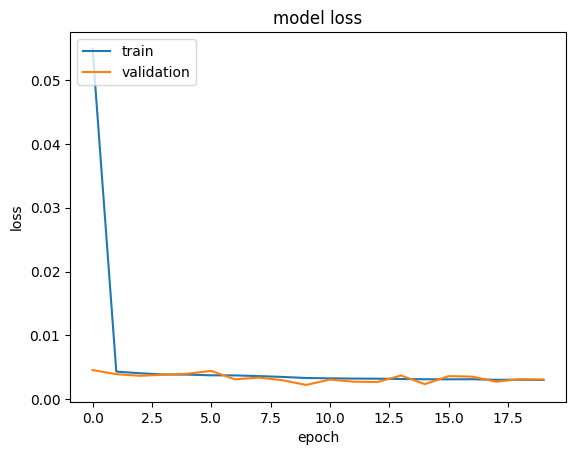

Evaluate on training data
2471/2471 [==============================] - 3s 1ms/step - loss: 0.0030
training loss: 0.003044531447812915
Evaluate on test data
655/655 [==============================] - 1s 1ms/step - loss: 0.0030
test loss: 0.0029963578563183546


In [9]:
# Loss
plt.plot(history_map.history['loss'])
plt.plot(history_map.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_map.evaluate(train_map_features, train_map_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_map.evaluate(test_map_features, test_map_labels, batch_size=128)
print("test loss:", results)

In [10]:
# model_map = keras.models.load_model("model_map_params.tf")
# dt = 0.2
# steps = 200
# ax5 = plt.figure().add_subplot(projection='3d')
# ax6 = plt.figure().add_subplot()

# def integrate2(params):
#     res_ar = []
#     val_model = val_rk = val_0
#     time = 0.0
#     for i in range(steps):
#         val_rk = f_rk(val_rk, params, dt)
#         #print(val_rk)
#         #print(np.concatenate((val_model, np.array(params_0).flatten())))
#         val_model = model_map.predict(np.concatenate((val_model, np.array(params).flatten())))[0]
#         time += dt
#         res_ar.append([time, val_model, val_rk])
#     res_ar = np.array(res_ar, dtype = object)
#     return res_ar
# def add_trajectory2(params):
#     res_ar = integrate2(params)
#     # ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
#     # ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Model predicted plot
#     ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,2]], color="blue", label="Runge-Kutta")
#     ax6.plot(res_ar[:,0], [row[0] for row in res_ar[:,1]], color="red", label="Neural Network")

# # ran_sam = np.random.random_sample(size=(10, 3, 2))
# # ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
# # for s in ran_sam:
# #     add_trajectory2(np.array(params_0)-np.multiply(params_0,s))
# add_trajectory2(np.array(params_0)*0.15)

# plt.rcParams["figure.autolayout"] = True
# leg = plt.legend(loc='upper right')
# # Set axes labels
# ax5.set_xlabel("S0")
# ax5.set_ylabel("S1")
# ax5.set_zlabel("S2")
# ax5.set_title("Runge-Kutta vs Model Trajectories")

# ax6.set_xlabel("Time")
# ax6.set_ylabel("Value")
# ax6.set_title("S0 Trajectory")
# plt.show()

### Building and training the differential equation model

In [11]:
normalizer_dif = layers.Normalization(axis=-1)
normalizer_dif.adapt(np.array(train_dif_features))
model_dif = keras.Sequential(
    [
        normalizer_dif,
        layers.Dense(15, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(3)
    ]
)
model_dif.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
model_dif.summary()

history_dif = model_dif.fit(
    train_dif_features,
    train_dif_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

model_dif.save("model_dif_params.tf", save_format="tf")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 15)                150       
                                                                 
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 438 (1.71 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


2023-09-07 22:36:20.393827: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18213120 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: model_dif_params.tf/assets


INFO:tensorflow:Assets written to: model_dif_params.tf/assets


### Evaluating the model

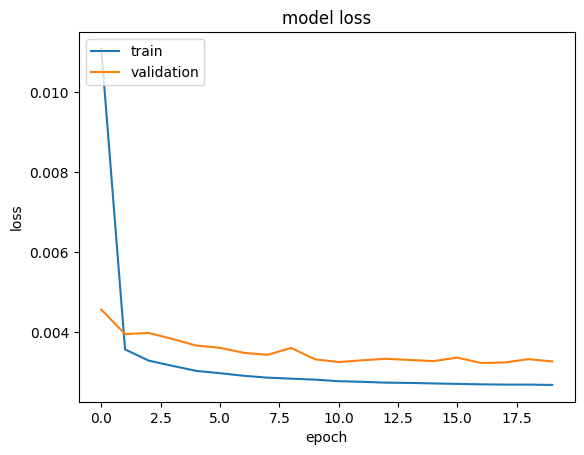

Evaluate on training data
 125/2471 [>.............................] - ETA: 2s - loss: 0.0023

2023-09-07 22:40:04.641681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22766400 exceeds 10% of free system memory.


2471/2471 [==============================] - 3s 1ms/step - loss: 0.0027
training loss: 0.0027429379988461733
Evaluate on test data
655/655 [==============================] - 1s 1ms/step - loss: 0.0023
test loss: 0.0023474819026887417


In [12]:
# Loss
plt.plot(history_dif.history['loss'])
plt.plot(history_dif.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = model_dif.evaluate(train_dif_features, train_dif_labels, batch_size=128)
print("training loss:", results)
print("Evaluate on test data")
results = model_dif.evaluate(test_dif_features, test_dif_labels, batch_size=128)
print("test loss:", results)

1/1 [==============================] - 0s 18ms/step
Differential NN Error in Steady State:  0.01728271280626473 Time-1 Map NN Error in Steady State:  2.834386909079162
1/1 [==============================] - 0s 19ms/step
Differential NN Error in Steady State:  2.354425855444254 Time-1 Map NN Error in Steady State:  0.9729056876272356
1/1 [==============================] - 0s 19ms/step
Differential NN Error in Steady State:  0.02827682661959442 Time-1 Map NN Error in Steady State:  0.34346284706859126
1/1 [==============================] - 0s 18ms/step
Differential NN Error in Steady State:  0.03696387114601843 Time-1 Map NN Error in Steady State:  0.16930865972060055
1/1 [==============================] - 0s 27ms/step
Differential NN Error in Steady State:  0.07917944803780624 Time-1 Map NN Error in Steady State:  0.5797451688702412
1/1 [==============================] - 0s 23ms/step
Differential NN Error in Steady State:  0.06312144158484628 Time-1 Map NN Error in Steady State:  0.4915

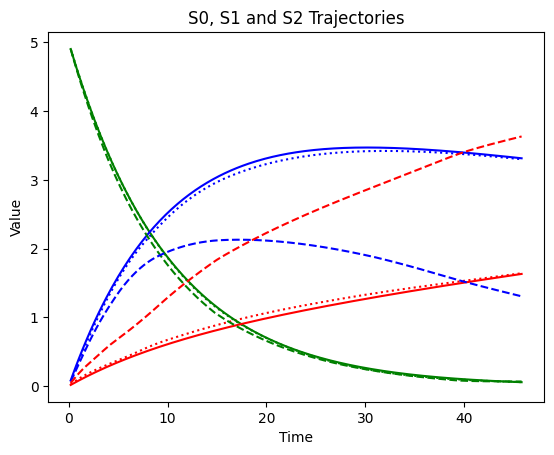

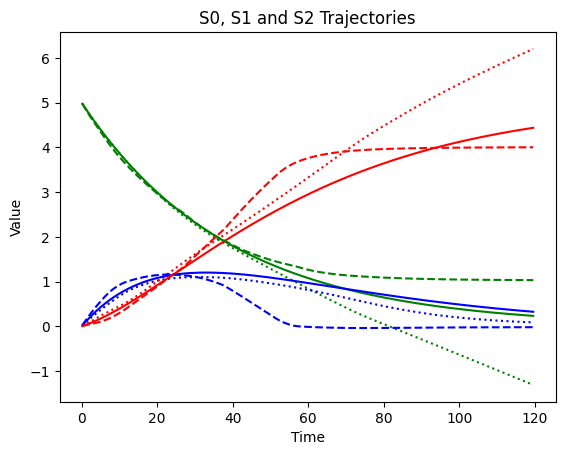

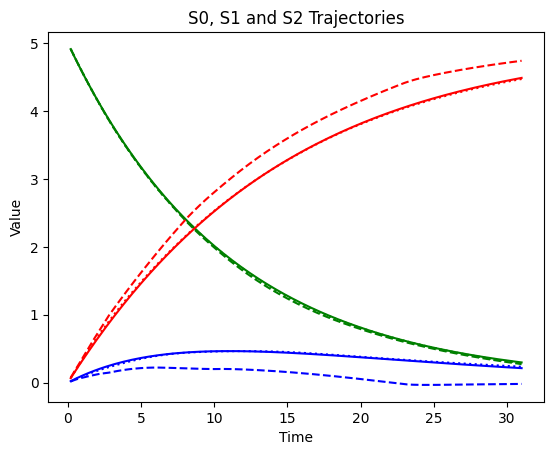

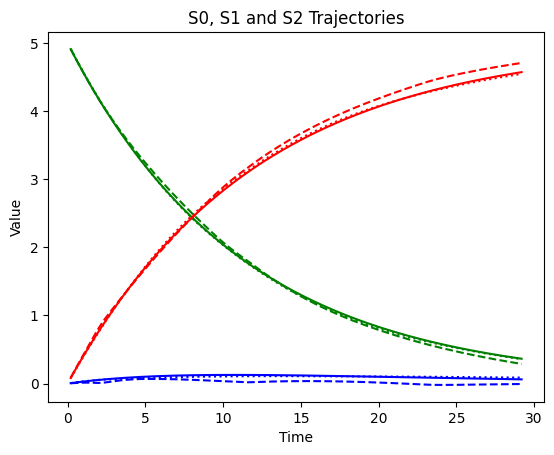

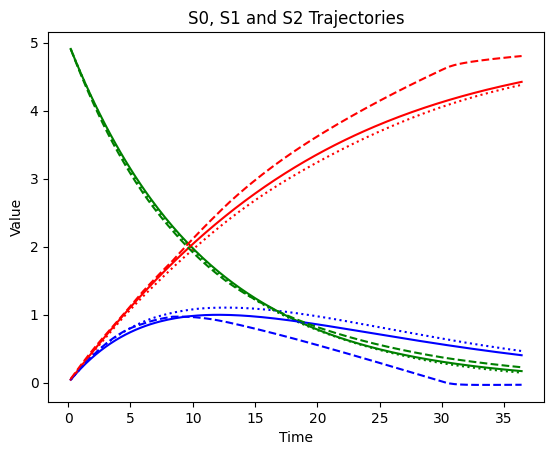

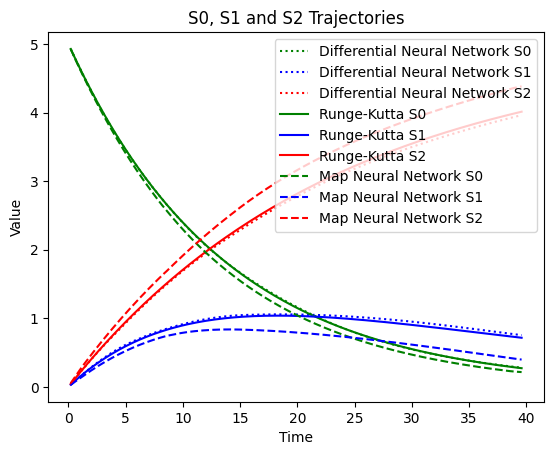

In [13]:
model_dif = keras.models.load_model("model_dif_params.tf")
model_map = keras.models.load_model("model_map_params.tf")
dt = 0.2
# steps = 200

# ax5 = plt.figure().add_subplot(projection='3d')
# ax6 = plt.figure().add_subplot()

def f2(val, params):#based on the NN
    return model_dif.predict(np.concatenate((val, np.array(params).flatten())))[0]

def f_rk2(val, params, dt):
    k_1 = f2(val, params)*dt
    k_2 = f2(val + 0.5*k_1, params)*dt
    k_3 = f2(val + 0.5*k_2, params)*dt
    k_4 = f2(val + k_3, params)*dt
    nval = val + (1/6)*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return nval
def integrate3(params):
    res_ar = []
    val_map = val_rk = val_dif = val_0
    time = 0.0
    while(True):
        nval_rk = f_rk(val_rk, params, dt)
        nval_map = model_map.predict(np.concatenate((val_map, np.array(params).flatten())))[0]
        nval_dif = f_rk2(val_dif, params, dt)
        scaled_norm_rk = np.linalg.norm(nval_rk-val_rk)/np.linalg.norm(val_0)
        scaled_norm_map = np.linalg.norm(nval_map-val_map)/np.linalg.norm(val_0)
        scaled_norm_dif = np.linalg.norm(nval_dif-val_dif)/np.linalg.norm(val_0)
        if(scaled_norm_rk < 0.002 and scaled_norm_map < 0.002 and scaled_norm_dif < 0.002): # all have reached steady state
            dif_dif = np.linalg.norm(val_dif-val_rk)
            dif_map = np.linalg.norm(val_map-val_rk)
            break
        val_rk = nval_rk
        val_map = nval_map
        val_dif = nval_dif
        time += dt
        res_ar.append([time, val_map, val_rk, val_dif])
    res_ar = np.array(res_ar, dtype = object)
    return dif_dif, dif_map, res_ar
def add_trajectory3(params):
    dif_dif, dif_map, res_ar = integrate3(params)
    print("Differential NN Error in Steady State: ",dif_dif, "Time-1 Map NN Error in Steady State: ",dif_map)
    # ax5.plot([row[0] for row in res_ar[:,3]], [row[1] for row in res_ar[:,3]], [row[2] for row in res_ar[:,3]], color="green", label="Differential Neural Network")#Dif NN plot
    # ax5.plot([row[0] for row in res_ar[:,2]], [row[1] for row in res_ar[:,2]], [row[2] for row in res_ar[:,2]], color="blue", label="Runge Kutta")#Runge Kutta plot
    # ax5.plot([row[0] for row in res_ar[:,1]], [row[1] for row in res_ar[:,1]], [row[2] for row in res_ar[:,1]], color="red", label="Model Predicted")#Map NN plot
    ax = plt.figure().add_subplot()
    ax.plot(res_ar[:,0], [row[0] for row in res_ar[:,3]], "g:", label="Differential Neural Network S0")
    ax.plot(res_ar[:,0], [row[1] for row in res_ar[:,3]], "b:", label="Differential Neural Network S1")
    ax.plot(res_ar[:,0], [row[2] for row in res_ar[:,3]], "r:", label="Differential Neural Network S2")
    ax.plot(res_ar[:,0], [row[0] for row in res_ar[:,2]], "g-", label="Runge-Kutta S0")
    ax.plot(res_ar[:,0], [row[1] for row in res_ar[:,2]], "b-", label="Runge-Kutta S1")
    ax.plot(res_ar[:,0], [row[2] for row in res_ar[:,2]], "r-", label="Runge-Kutta S2")
    ax.plot(res_ar[:,0], [row[0] for row in res_ar[:,1]], "g--", label="Map Neural Network S0")
    ax.plot(res_ar[:,0], [row[1] for row in res_ar[:,1]], "b--", label="Map Neural Network S1")
    ax.plot(res_ar[:,0], [row[2] for row in res_ar[:,1]], "r--", label="Map Neural Network S2")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title("S0, S1 and S2 Trajectories")

# add_trajectory3(np.array(params_0)*0.15)
# ran_sam = np.random.random_sample(size=(10, 3, 2))
# ran_sam = [(sam*0.25+np.array([[0.5,0.5],[0.5,0.5],[0.5,0.5]])*1.5) for sam in ran_sam]#random sample of deviation -75% -> -100%
# for s in ran_sam:
#     add_trajectory3(np.array(params_0)-np.multiply(params_0,s))
for i in range(6):
    params = random.choice(test_params)
    add_trajectory3(params)
plt.rcParams["figure.autolayout"] = True
leg = plt.legend(loc='upper right')
# Set axes labels
# ax5.set_xlabel("S0")
# ax5.set_ylabel("S1")
# ax5.set_zlabel("S2")
# ax5.set_title("Runge-Kutta vs Model Trajectories")

# ax6.set_xlabel("Time")
# ax6.set_ylabel("Value")
# ax6.set_title("S0, S1 and S2 Trajectories")
plt.show()